In [2]:
import wandb
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [3]:
interesting_runs = []
api = wandb.Api()


In [4]:
runs = api.runs("saleml/hvi_paper_final")
for run in runs:
    if run.state == 'finished':
        interesting_runs.append(run)
extra_runs = api.runs("saleml/hvi_paper_extra")
for run in extra_runs:
    if run.state == 'finished':
        interesting_runs.append(run)


In [5]:
groups = {}
configs = {}
for mode in ['tb', 'reverse_kl', 'rws', 'forward_kl', 'reverse_rws', 'modified_db']:
    for sampling_mode in ['on_policy', 'pure_off_policy', 'off_policy']:
        name = f"{mode}_{sampling_mode}"
        groups[name] = []
        configs[name] = []
        for run in interesting_runs:
            if run.config['mode'] == mode and run.config['sampling_mode'] == sampling_mode:
                groups[name].append(run.history())
                configs[name].append(run.config)


In [6]:
excluded_keys = ['seed', 'wandb', 'offset', 'no_cuda', 'task_id', 'config_id', 'gradient_estimation_interval', 'validation_interval', 'total']

In [7]:
def get_group_average(group, column_name):
    "takes a list of dataframes as input and returns a numpy array of the average of the column across the dataframes, and same for std"
    return (np.mean(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0),
     np.std(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0))

In [8]:
def where_different(list_of_tuples):
    "Returns the list of indices where the values in the tuples are different"
    return [i for i, x in enumerate(zip(*list_of_tuples)) if len(set(x)) > 1]

def discrimative_tuples(list_of_tuples):
    out = []
    for tupl in list_of_tuples:
        new_tupl = (val for i, val in enumerate(tupl) if i in where_different(list_of_tuples))
        out.append(tuple(new_tupl))
    return out

In [32]:
short_keys = {'exploration_phase_ends_by': 'exp', 'replay_capacity': 'rep', 'lr_scheduling': 'lrs', 'schedule': 'sch', 'baseline': 'b'}
for key in configs['tb_on_policy'][0].keys():
    if key not in short_keys:
        short_keys[key] = key

In [57]:
def group_by_everything_but_excluded_keys(group, configs, excluded_keys):
    "takes a list of dataframes and a list of configs and returns a dictionary of dataframes grouped by everything but the excluded_keys"
    groups = {}
    for i, config in enumerate(configs):
        new_key = tuple([(key, config[key]) for key in list(config.keys()) if key not in excluded_keys])
        if new_key not in groups:
            groups[new_key] = []
        groups[new_key].append(group[i])
    return groups


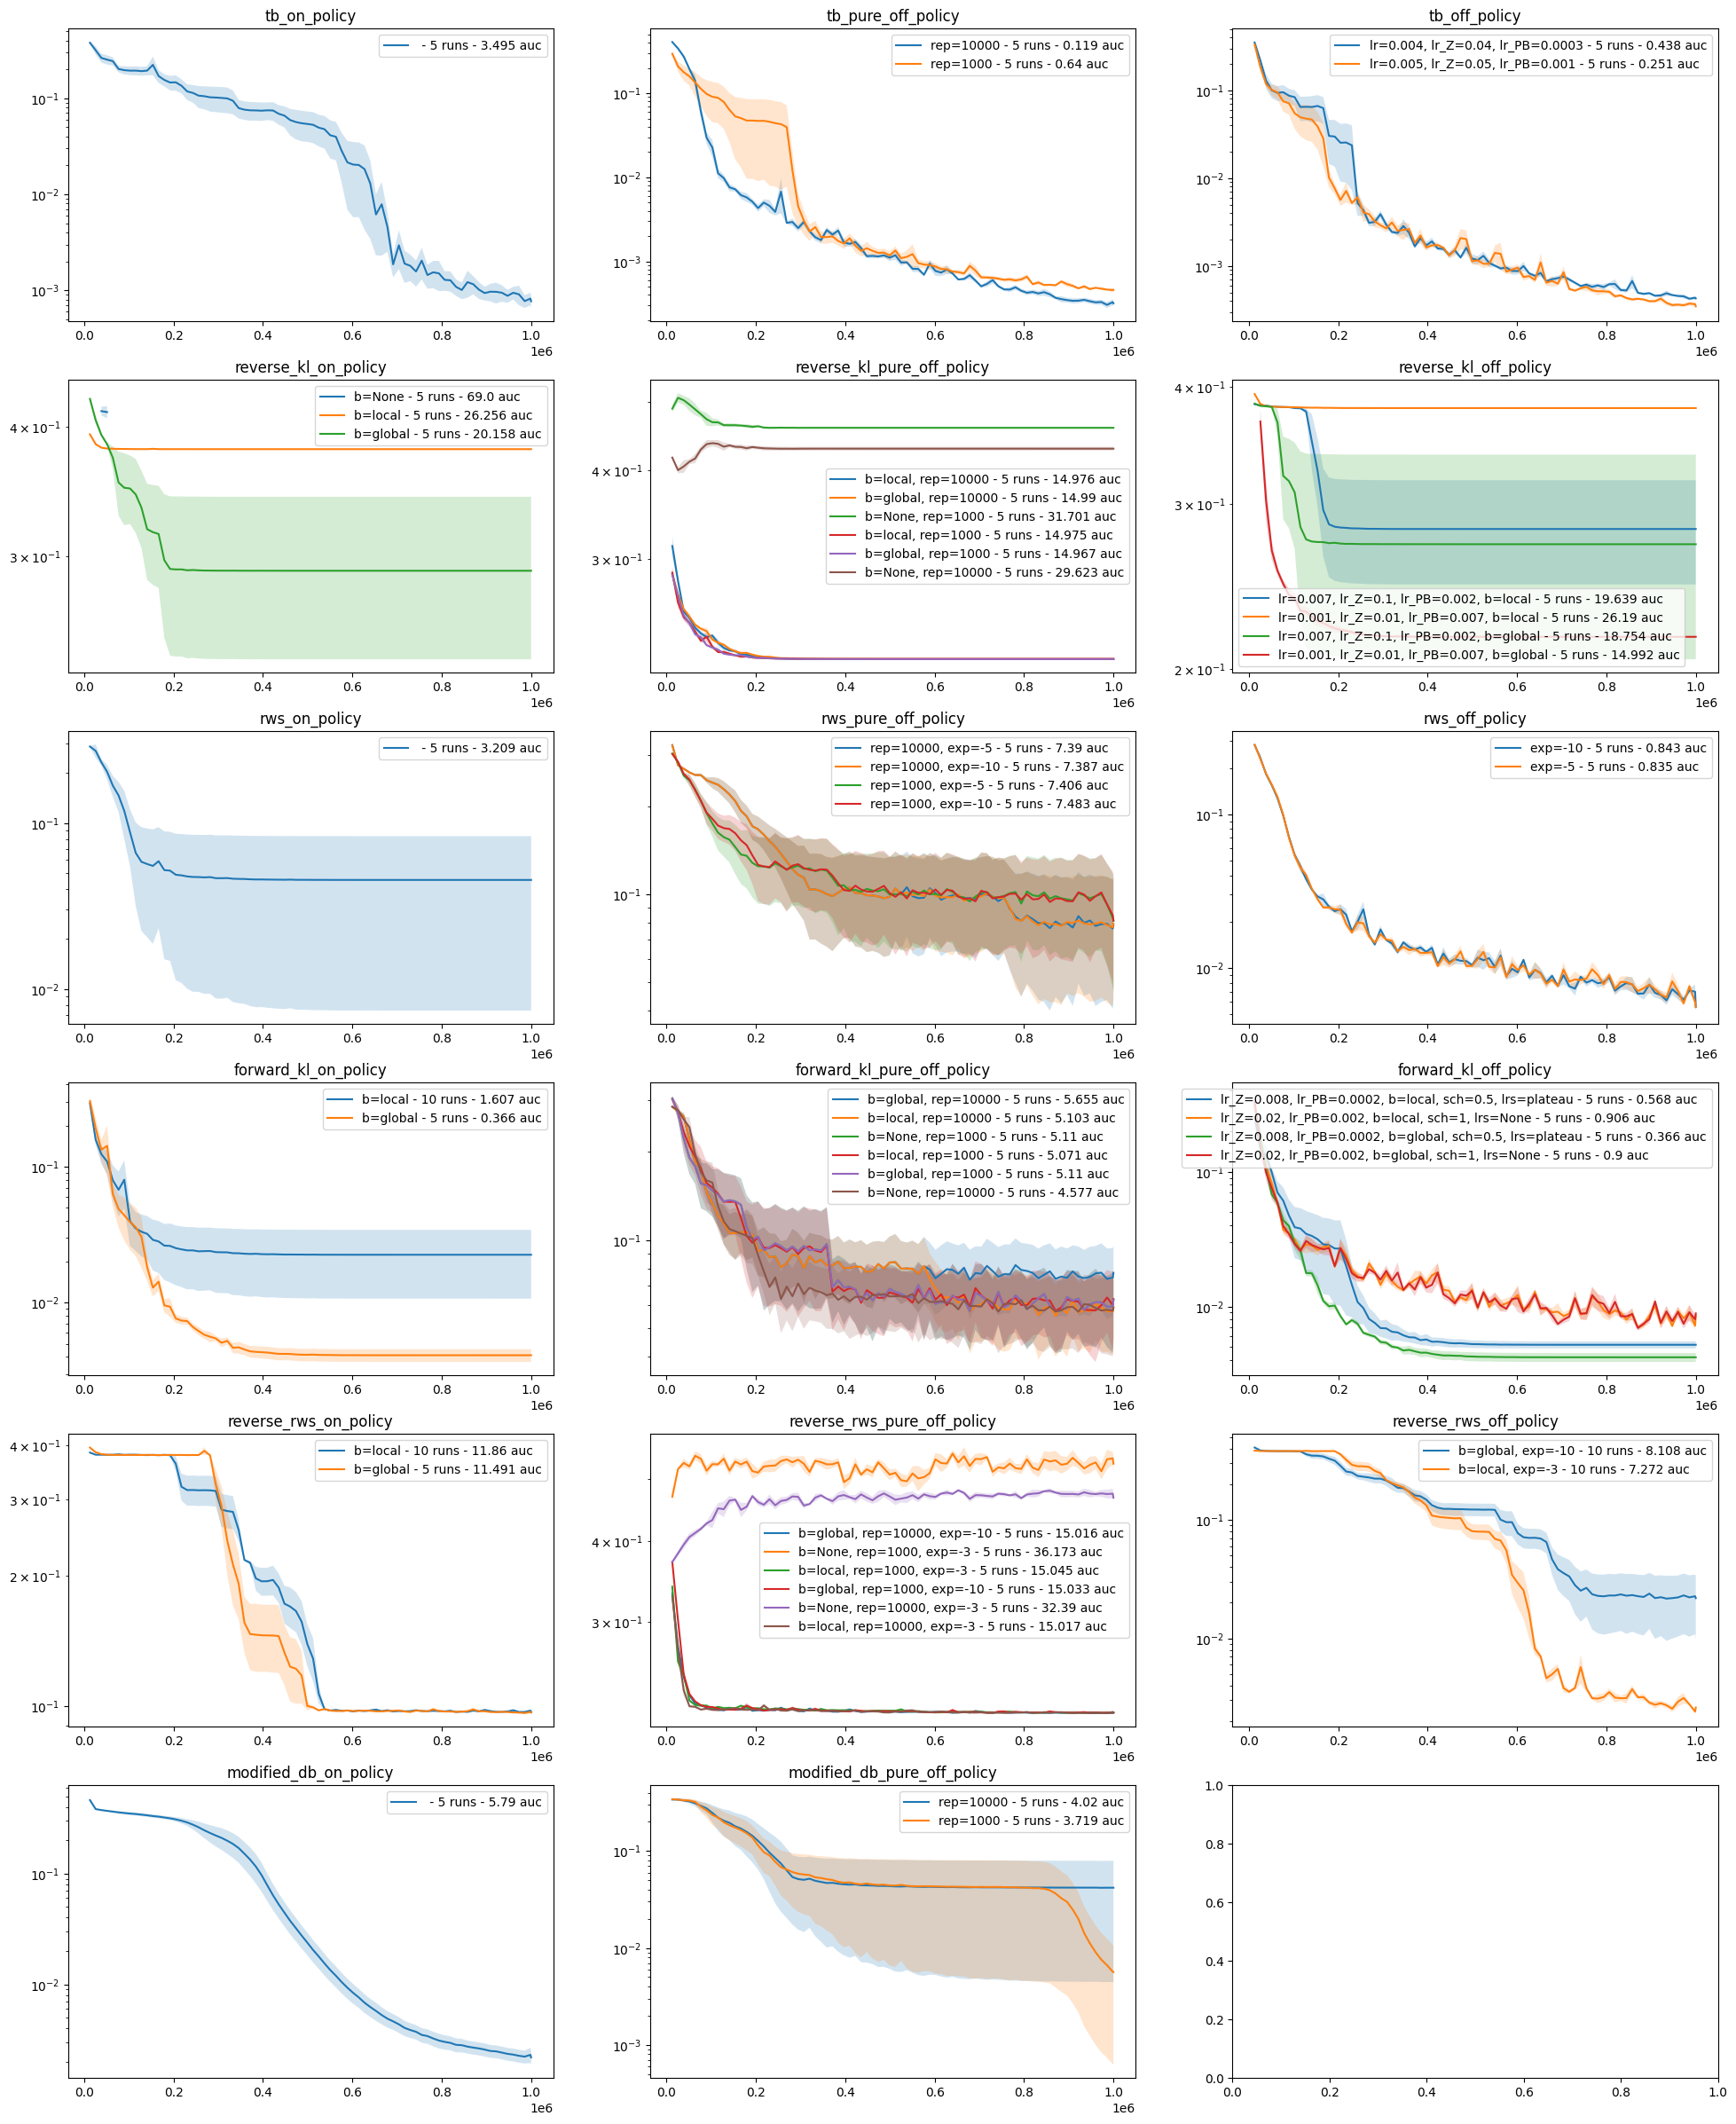

In [58]:
# Here, we show all modes and sampling modes, and for each of them the different configs tried (averaged over seeds)

plt.subplots(6, 3, figsize=(24, 30))
best_key_per_mode = {}
for name in groups.keys():
    gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
    keys = list(gs.keys())
    discriminative_keys = discrimative_tuples(keys)
    best_auc = float('inf')
    for key, discriminative_key in zip(keys, discriminative_keys):
        pretty_discriminative_key = ", ".join([f"{short_keys[k]}={v}" for k, v in discriminative_key])
        mean, std = get_group_average(gs[key], 'jsd')
        auc = np.trapz(np.nan_to_num(mean[10:], nan=1.))
        if auc < best_auc:
            best_auc = auc
            best_key_per_mode[name] = key
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))
        plt.subplot(6, 3, list(groups.keys()).index(name) + 1)
        plt.plot(states_visited, mean, label=f"{pretty_discriminative_key} - {len(gs[key])} runs - {np.round(auc, 3)} auc")
        plt.fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
        ax = plt.gca()
        ax.set_yscale('log')
        plt.title(name)
        plt.legend()
plt.show()


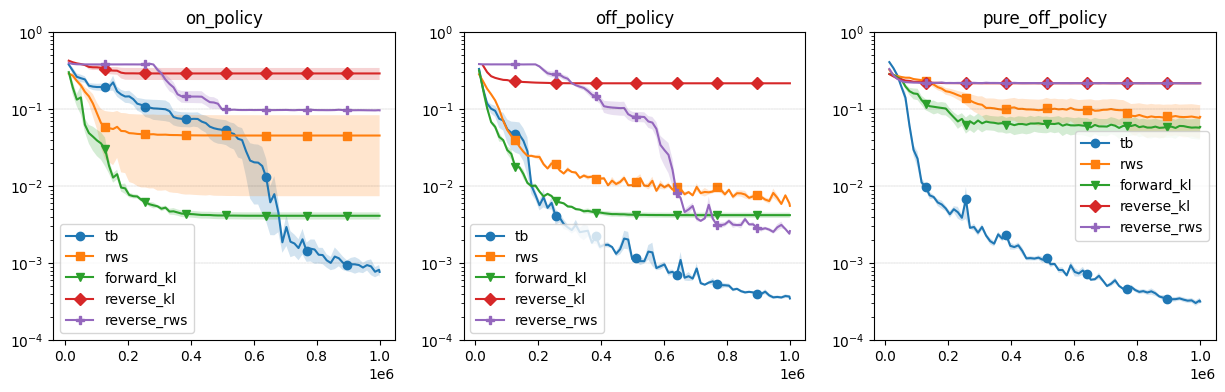

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
markers = ['o', 's', 'v', 'D', 'P', 'H', 'X']
for i, sampling_mode in enumerate(['on_policy', 'off_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        name = f"{mode}_{sampling_mode}"
        gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
        key = best_key_per_mode[name]
        mean, std = get_group_average(gs[key], 'jsd')
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))
        axes[i].plot(states_visited, mean, label=f"{mode}", marker=markers[j], markevery=10)
        axes[i].fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4, 1)
    axes[i].set_title(sampling_mode)
    axes[i].legend()
    # add thin horizontal lines
    for y in [1e-3, 1e-2, 1e-1]:
        axes[i].axhline(y=y, color='k', linestyle='--', linewidth=0.1)

plt.show()


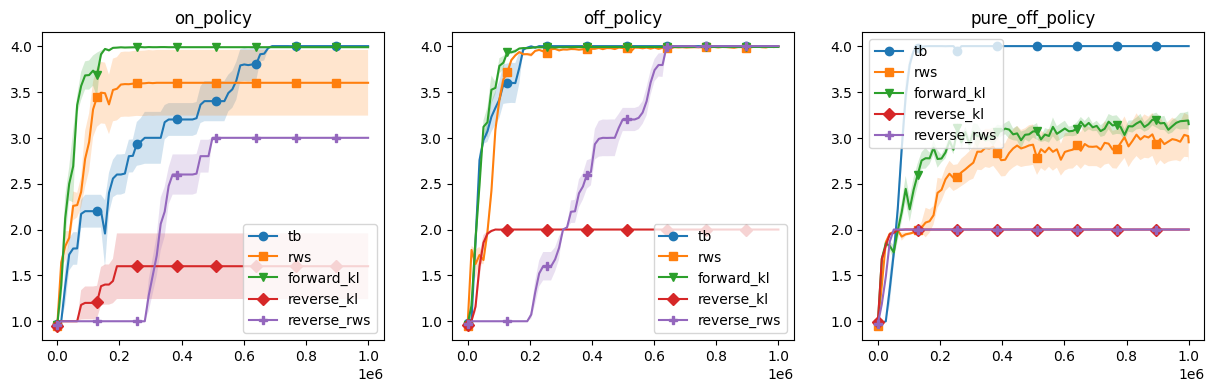

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
markers = ['o', 's', 'v', 'D', 'P', 'H', 'X']
for i, sampling_mode in enumerate(['on_policy', 'off_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        name = f"{mode}_{sampling_mode}"
        gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
        key = best_key_per_mode[name]
        mean, std = get_group_average(gs[key], 'modes_found')
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))
        axes[i].plot(states_visited, mean, label=f"{mode}", marker=markers[j], markevery=10)
        axes[i].fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
    axes[i].set_title(sampling_mode)
    axes[i].legend()


plt.show()


In [61]:
best_key_per_mode['tb_on_policy']

(('PB', 'learnable'),
 ('R0', 0.1),
 ('lr', 0.004),
 ('env', 'very_hard'),
 ('lr_Z', 0.04),
 ('mode', 'tb'),
 ('ndim', 2),
 ('lr_PB', 0.0003),
 ('height', 8),
 ('baseline', 'None'),
 ('no_wandb', False),
 ('schedule', 0.9),
 ('batch_size', 64),
 ('early_stop', 0),
 ('reward_cos', False),
 ('failed_runs', False),
 ('init_epsilon', 0),
 ('final_epsilon', 0),
 ('lr_scheduling', 'plateau'),
 ('sampling_mode', 'on_policy'),
 ('n_trajectories', 1000000),
 ('temperature_sf', True),
 ('replay_capacity', 1000),
 ('init_temperature', 0),
 ('final_temperature', 1),
 ('bilevel_exploration', False),
 ('multi_step_milestones', 2),
 ('temperature_sf_string', 'False'),
 ('exploration_scheduling', 'cosine'),
 ('exploration_phase_ends_by', -1))

In [63]:
def is_dict_consistent_with_list_of_tuples(d, l):
    # Checks if the values in the dictionary are consistent with the values in the list of tuples, for the common keys
    for key in d.keys():
        if key in [elem[0] for elem in l]:
            if d[key] != [elem[1] for elem in l if elem[0] == key][0]:
                return False
    return True

In [64]:
import os
for run in interesting_runs:
    mode = run.config['mode']
    sampling_mode = run.config['sampling_mode']
    name = f"{mode}_{sampling_mode}"
    best_key = best_key_per_mode[name]
    if not is_dict_consistent_with_list_of_tuples(run.config, best_key):
        continue
    print(f"Processing {run.name}")
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    name = f"{run.config['mode']}_{run.config['sampling_mode']}_best_{run.config['seed']}"
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            file.download(replace=True)
            file_directory = os.path.join(os.getcwd(), 'media', 'images')
            os.rename(file.name, os.path.join(file_directory, f"{name}.png"))

Processing hvi_paper_final_182
Processing hvi_paper_final_184
Processing hvi_paper_final_178
Processing hvi_paper_final_164
Processing hvi_paper_final_159
Processing hvi_paper_final_161
Processing hvi_paper_final_158
Processing hvi_paper_final_157
Processing hvi_paper_final_155
Processing hvi_paper_final_151
Processing hvi_paper_final_156
Processing hvi_paper_final_153
Processing hvi_paper_final_189
Processing hvi_paper_final_144
Processing hvi_paper_final_146
Processing hvi_paper_final_140
Processing hvi_paper_final_121
Processing hvi_paper_final_123
Processing hvi_paper_final_126
Processing hvi_paper_final_117
Processing hvi_paper_final_120
Processing hvi_paper_final_119
Processing hvi_paper_final_118
Processing hvi_paper_final_115
Processing hvi_paper_final_113
Processing hvi_paper_final_106
Processing hvi_paper_final_108
Processing hvi_paper_final_102
Processing hvi_paper_final_85
Processing hvi_paper_final_88
Processing hvi_paper_final_79
Processing hvi_paper_final_83
Processing h

In [ ]:
from PIL import Image
import os
import matplotlib

def filename_to_mode(filename):
    if 'forward_kl' in filename:
        return 'Forward KL'
    elif 'reverse_kl' in filename:
        return 'Reverse KL'
    elif 'reverse_rws' in filename:
        return 'Reverse RWS'
    elif 'modified_db' in filename:
        return 'Modified DB'
    elif 'tb' in filename:
        return 'Trajectory Balance'
    elif 'rws' in filename:
        return 'RWS'
    else:
        return 'Unknown'

def filename_to_sampling_mode(filename):
    if 'on_policy' in filename:
        return 'On-Policy'
    elif 'off_policy' in filename and 'pure' not in filename:
        return 'Off-Policy'
    elif 'pure_off_policy' in filename:
        return 'Pure-Off-Policy'
    else:
        return 'Unknown'

files = os.listdir('media/images')
algs = [ f[:-4] for f in files ]
algos = {}
for image in files:
    if 'best' not in image:
        continue
    key = filename_to_mode(image) + '_' + filename_to_sampling_mode(image)
    if key not in algos.keys():
        algos[key] = []
    image = np.array(Image.open(os.path.join('media/images', image))) / 255. 
    g = image[62:445:3,66:449:3]
    c = np.array(matplotlib.cm.viridis.colors)
    v = ((g[...,:3,None]-c.T)**2).sum(-2).argmin(-1) / 255.
    algos[key].append(v[::-1])

average_images = {key: np.array(val).mean(0) for key, val in algos.items()}

# target distribution
truev = np.copy(average_images['Trajectory Balance_Off-Policy'])
truev[(truev>0)*(truev<100/255.)] = 51/255.
truev[truev>51/255.]=1




In [72]:
average_images.keys()

dict_keys(['Modified DB_On-Policy', 'Forward KL_On-Policy', 'Reverse RWS_Off-Policy', 'Trajectory Balance_Pure-Off-Policy', 'RWS_Pure-Off-Policy', 'RWS_Off-Policy', 'Reverse KL_Off-Policy', 'Forward KL_Off-Policy', 'Modified DB_Pure-Off-Policy', 'Forward KL_Pure-Off-Policy', 'RWS_On-Policy', 'Reverse RWS_Pure-Off-Policy', 'Trajectory Balance_On-Policy', 'Reverse KL_Pure-Off-Policy', 'Reverse RWS_On-Policy', 'Trajectory Balance_Off-Policy', 'Reverse KL_On-Policy'])

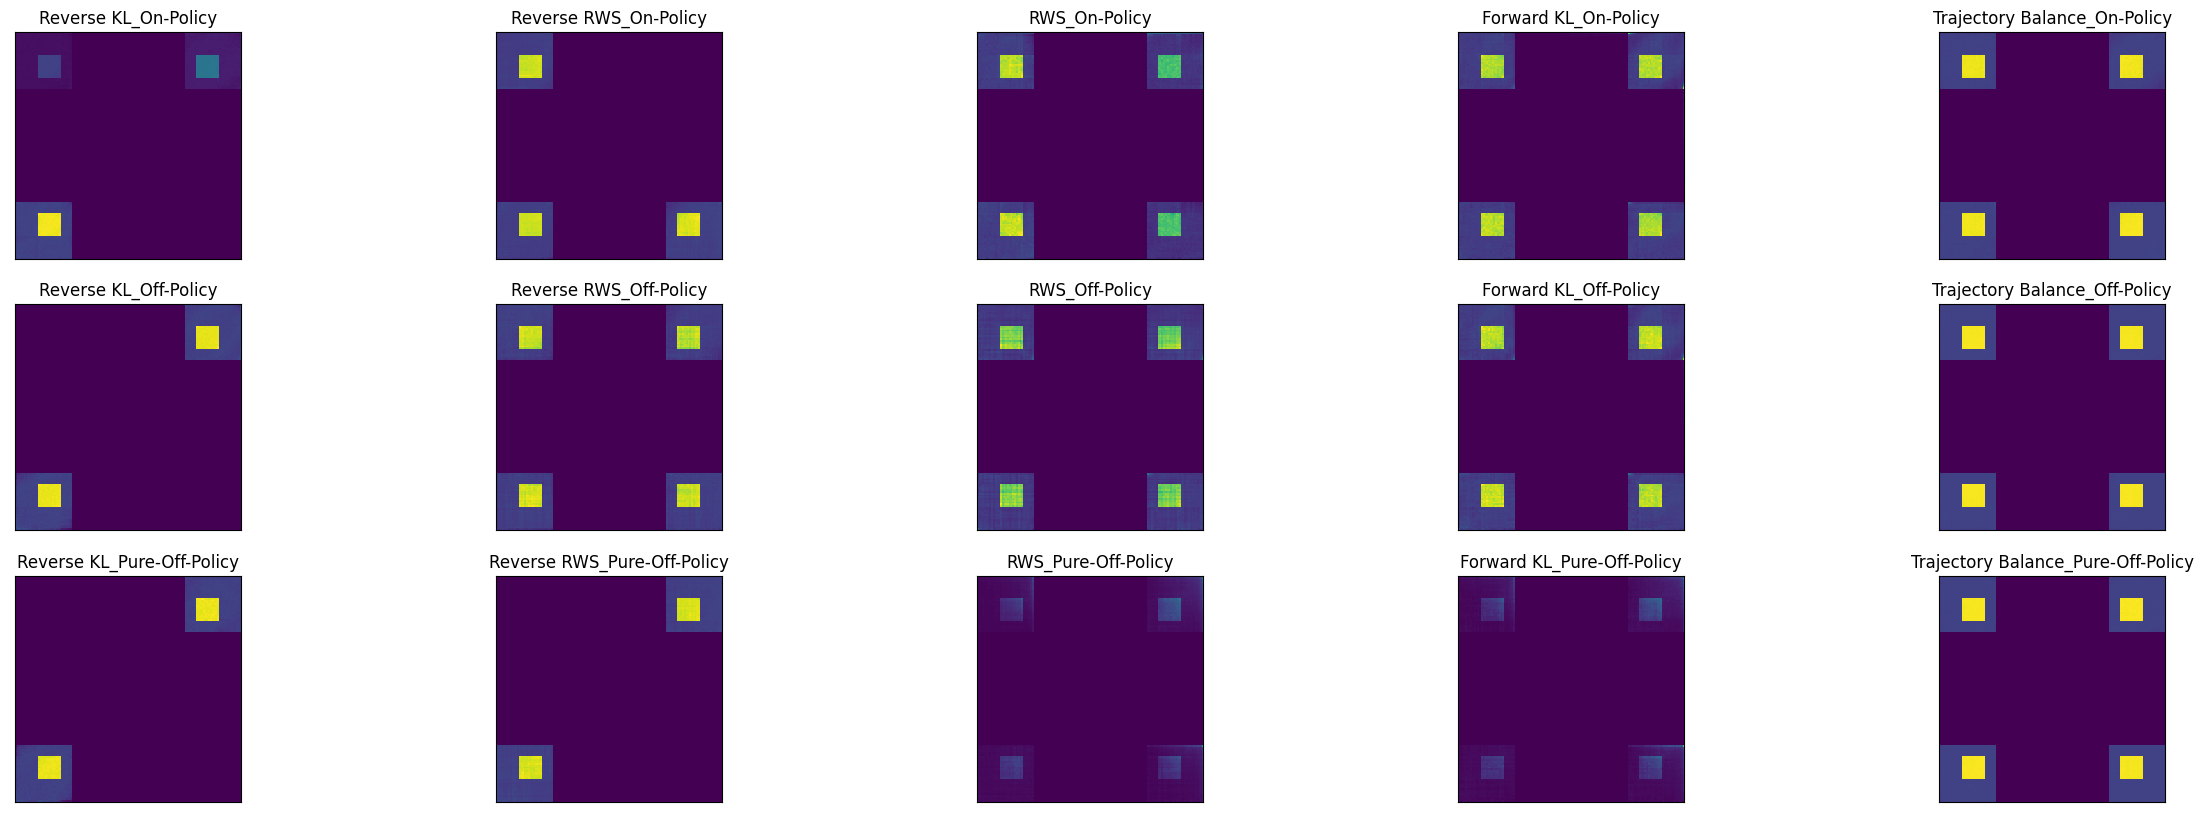

In [74]:
plt.figure(figsize=(30, 10))
i = 1
for sampling_mode in ['On-Policy', 'Off-Policy', 'Pure-Off-Policy']:
    for mode in ['Reverse KL', 'Reverse RWS', 'RWS', 'Forward KL', 'Trajectory Balance']:
        key = f"{mode}_{sampling_mode}"
        plt.subplot(3, 5, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(average_images[key], cmap='viridis', interpolation='none')
        plt.title(key)
        i += 1
plt.show()

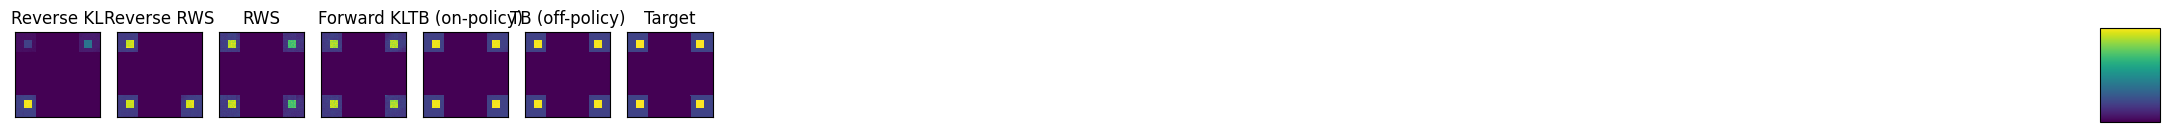

In [68]:
titles = {'Reverse KL_On-Policy': 'Reverse KL',
 'Reverse RWS_On-Policy': 'Reverse RWS',
 'RWS_On-Policy': 'RWS',
 'Forward KL_On-Policy': 'Forward KL',
 'Trajectory Balance_On-Policy': 'TB (on-policy)',
 'Trajectory Balance_Off-Policy': 'TB (off-policy)'}
plt.figure(figsize=(30, 2))
i = 1
for key in titles.keys():
    plt.subplot(1, 20, i)
    plt.xticks([]);plt.yticks([])
    plt.title(titles[key])
    plt.imshow(average_images[key], cmap='viridis', interpolation='none')
    i += 1
plt.subplot(1, 20, i)
plt.xticks([]);plt.yticks([])
plt.title('Target')
plt.imshow(truev, cmap='viridis', interpolation='none')
# add one colorbar for all subplots, and normalize the colors to [0, 1]
plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.82, 0.26, 0.02, 0.47])
plt.colorbar(cax=cbar_ax, ticks=[])
# plt.savefig('final_distributions.pdf', bbox_inches='tight')
plt.show()

### OLD

In [267]:
average_jsd = {}
std_jsd = {}
states_visited = {}
average_modes_found = {}
std_modes_found = {}
for key in groups.keys():
    if len(groups[key]) > 0:
        average_jsd[key] = get_group_average(groups[key], 'jsd')[0]
        std_jsd[key] = get_group_average(groups[key], 'jsd')[1]
        states_visited[key] = get_group_average(groups[key], 'states_visited')[0]
        average_modes_found[key] = get_group_average(groups[key], 'modes_found')[0]
        std_modes_found[key] = get_group_average(groups[key], 'modes_found')[1]



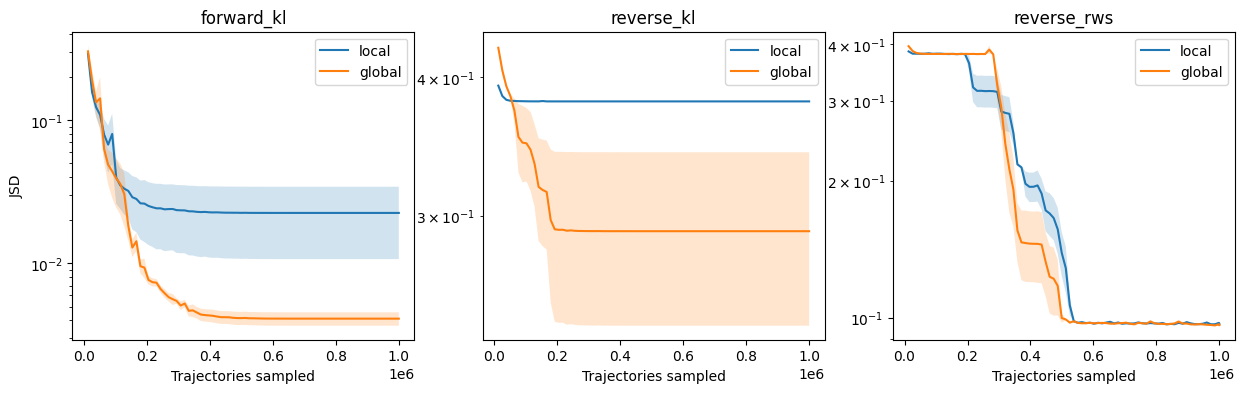

In [268]:
# Comparing the baseline for on-policy losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, mode in enumerate(['forward_kl', 'reverse_kl', 'reverse_rws']):
    for j, baseline in enumerate(['local', 'global']):
        group_name = f"{mode}_on_policy_{baseline}_1000"
        if group_name in average_jsd.keys():
            states_visited_j = states_visited[group_name]
            average_jsd_j = average_jsd[group_name]
            std_jsd_j = std_jsd[group_name]
            std_error_jsd_j = std_jsd_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_jsd_j, label=f"{baseline}")
            axes[i].fill_between(states_visited_j, average_jsd_j - std_error_jsd_j, average_jsd_j + std_error_jsd_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    axes[i].set_title(f"{mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.savefig('importance_of_baseline_on_policy.pdf', bbox_inches='tight')
plt.show()

In [229]:
better_keys = {'tb': 'Trajectory Balance (GFN)', 'modified_db': 'Modified DB (GFN)',
 'forward_kl': 'Forward KL', 'reverse_kl': 'Reverse KL', 'reverse_rws': 'Reverse RWS', 'rws': 'RWS'}

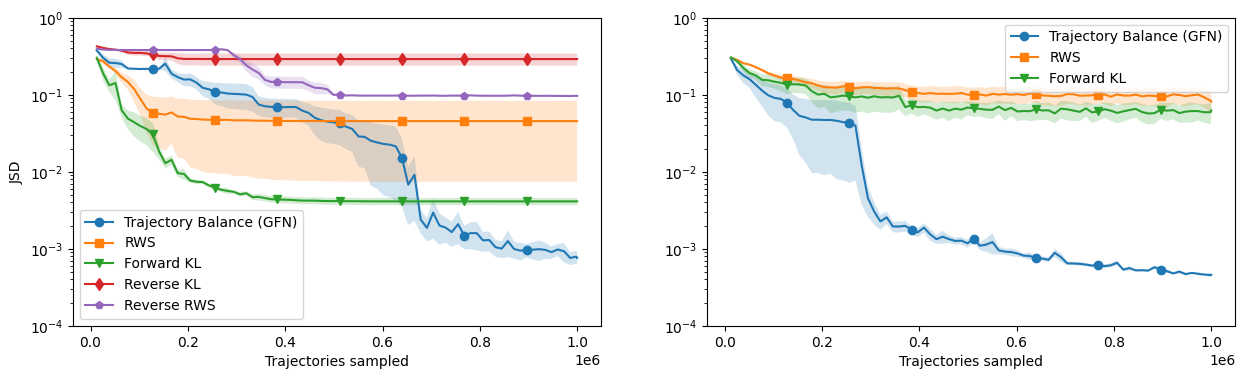

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
markers = ['o', 's', 'v', 'd', 'p', 'h', 'x', 'D', 'P', 'H', 'X']
for i, sampling_mode in enumerate(['on_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'forward_kl', 'reverse_kl', 'reverse_rws'] if sampling_mode == 'on_policy' else ['tb', 'rws', 'forward_kl']):
        baseline = 'global' if mode in ['forward_kl', 'reverse_kl', 'reverse_rws'] else 'None'
        group_name = f"{mode}_{sampling_mode}_{baseline}_1000"
        if group_name in average_jsd.keys():
            states_visited_j = states_visited[group_name]
            average_jsd_j = average_jsd[group_name]
            std_jsd_j = std_jsd[group_name]
            std_error_jsd_j = std_jsd_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_jsd_j, marker=markers[j], markevery=10, label=better_keys[mode])
            axes[i].fill_between(states_visited_j, average_jsd_j - std_error_jsd_j, average_jsd_j + std_error_jsd_j, alpha=0.2)
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4, 1)
    # axes[i].set_xscale('log')
    # axes[i].set_title(f"{sampling_mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.savefig('comparing_all_modes.pdf', bbox_inches='tight')
plt.show()

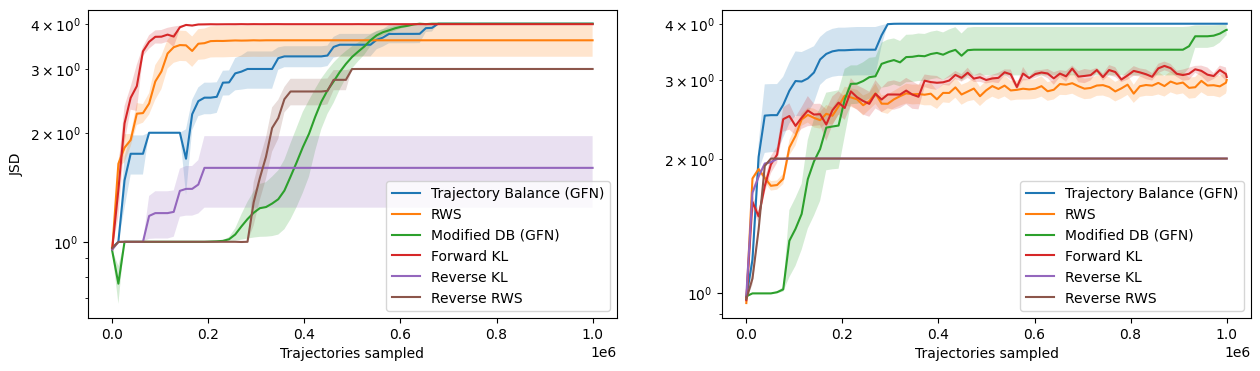

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i, sampling_mode in enumerate(['on_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'modified_db', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        baseline = 'global' if mode in ['forward_kl', 'reverse_kl', 'reverse_rws'] else 'None'
        group_name = f"{mode}_{sampling_mode}_{baseline}_1000"
        if group_name in average_modes_found.keys():
            states_visited_j = states_visited[group_name]
            average_modes_found_j = average_modes_found[group_name]
            std_modes_found_j = std_modes_found[group_name]
            std_error_modes_found_j = std_modes_found_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_modes_found_j, label=better_keys[mode])
            axes[i].fill_between(states_visited_j, average_modes_found_j - std_error_modes_found_j, average_modes_found_j + std_error_modes_found_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    # axes[i].set_title(f"{sampling_mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.show()

In [237]:
import os
for run in interesting_runs:
    if run.config['mode'] in ['reverse_kl', 'forward_kl', 'reverse_rws']:
        if run.config['baseline'] != 'global':
            continue
    if run.config['replay_capacity'] != 1000:
        continue
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    name = f"{run.config['mode']}_{run.config['sampling_mode']}_{run.config['baseline']}_{run.config['replay_capacity']}_{run.config['seed']}"
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            file.download(replace=True)
            file_directory = os.path.join(os.getcwd(), 'media', 'images')
            os.rename(file.name, os.path.join(file_directory, f"{name}.png"))



In [239]:
from PIL import Image
import os
import matplotlib

def filename_to_mode(filename):
    if 'forward_kl' in filename:
        return 'Forward KL'
    elif 'reverse_kl' in filename:
        return 'Reverse KL'
    elif 'reverse_rws' in filename:
        return 'Reverse RWS'
    elif 'modified_db' in filename:
        return 'Modified DB'
    elif 'tb' in filename:
        return 'Trajectory Balance'
    elif 'rws' in filename:
        return 'RWS'
    else:
        return 'Unknown'

def filename_to_sampling_mode(filename):
    if 'on_policy' in filename:
        return 'On-Policy'
    elif 'pure_off_policy' in filename:
        return 'Off-Policy'
    else:
        return 'Unknown'

files = os.listdir('media/images')
algs = [ f[:-4] for f in files ]
algos = {}
for image in files:
    key = filename_to_mode(image) + '_' + filename_to_sampling_mode(image)
    if key not in algos.keys():
        algos[key] = []
    image = np.array(Image.open(os.path.join('media/images', image))) / 255. 
    g = image[62:445:3,66:449:3]
    c = np.array(matplotlib.cm.viridis.colors)
    v = ((g[...,:3,None]-c.T)**2).sum(-2).argmin(-1) / 255.
    algos[key].append(v[::-1])

average_images = {key: np.array(val).mean(0) for key, val in algos.items()}

# target distribution
truev = np.copy(average_images['Trajectory Balance_Off-Policy'])
truev[(truev>0)*(truev<100/255.)] = 51/255.
truev[truev>51/255.]=1

titles = {'Reverse KL_On-Policy': 'Reverse KL',
 'Reverse RWS_On-Policy': 'Reverse RWS',
 'RWS_On-Policy': 'RWS',
 'Forward KL_On-Policy': 'Forward KL',
 'Trajectory Balance_On-Policy': 'TB (on-policy)',
 'Trajectory Balance_Off-Policy': 'TB (off-policy)'}
plt.figure(figsize=(12, 2))
i = 1
for key in titles.keys():
    plt.subplot(1, 7, i)
    plt.xticks([]);plt.yticks([])
    plt.title(titles[key])
    plt.imshow(average_images[key], cmap='viridis', interpolation='none')
    i += 1
plt.subplot(1, 7, i)
plt.xticks([]);plt.yticks([])
plt.title('Target')
plt.imshow(truev, cmap='viridis', interpolation='none')
# add one colorbar for all subplots, and normalize the colors to [0, 1]
plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.82, 0.26, 0.02, 0.47])
plt.colorbar(cax=cbar_ax, ticks=[])
plt.savefig('final_distributions.pdf', bbox_inches='tight')
plt.show()


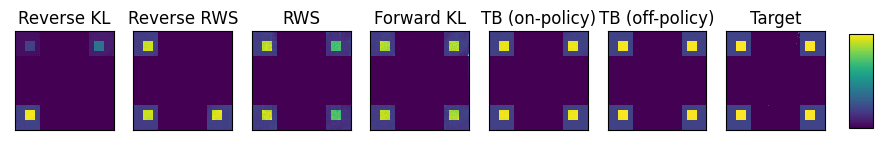